In [20]:
import os
import cv2
import glob2
import pydicom
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import exposure
import sys
sys.path.insert(0, '')
from mask_functions import *

In [21]:
sz = 256
sz0 = 1024
PATH_TRAIN0 = 'data/dicom-images-train/'
PATH_TRAIN1 = 'data/dicom-images-test/'
PATH_TEST = 'data/stage_2_images'
train_out = 'data/train.zip'
test_out = 'data/test.zip'
mask_out = 'data/masks.zip'
train = glob2.glob(os.path.join(PATH_TRAIN0, '**/*.dcm'))+glob2.glob(os.path.join(PATH_TRAIN1, '**/*.dcm'))
test = glob2.glob(os.path.join(PATH_TEST, '**/*.dcm'))

In [22]:
df = pd.read_csv('data/stage_2_train.csv').set_index('ImageId')
idxs = set(df.index)
train_names = []
for f in train: #remove images without labels
    name = f.split('/')[-1][:-4]
    if name in idxs: train_names.append(f)

In [23]:
def convert_images(filename, arch_out, sz=sz):
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array
    img = cv2.resize(img, (sz, sz))
    img = exposure.equalize_adapthist(img) # contrast correction
    x_tot = img.mean() #image statistics
    x2_tot = (img**2).mean()
    img = ((img*255)).clip(0,255).astype(np.uint8)
    output = cv2.imencode('.png',img)[1]
    name = filename.split('/')[-1][:-4] + '.png'
    arch_out.writestr(name, output)
    return x_tot, x2_tot

def get_stats(stats): # get dataset statistics 
    x_tot, x2_tot = 0.0, 0.0
    for x, x2 in stats:
        x_tot += x
        x2_tot += x2
    
    img_avr =  x_tot/len(stats)
    img_std =  np.sqrt(x2_tot/len(stats) - img_avr**2)
    print('mean:',img_avr, ', std:', img_std)

In [24]:
len(train)

15294

In [25]:
trn_stats = []
with zipfile.ZipFile(train_out, 'w') as arch:
    for fname in tqdm(train_names, total=len(train_names)):
        trn_stats.append(convert_images(fname,arch))

test_stats = []        
with zipfile.ZipFile(test_out, 'w') as arch:
    for fname in tqdm(test, total=len(test)):
        test_stats.append(convert_images(fname,arch))

/home/sahand/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/home/sahand/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [26]:
get_stats(trn_stats)
get_stats(test_stats)

mean: 0.5400871519286912 , std: 0.2643793121609704
mean: 0.5380999482609787 , std: 0.26491678657073864


In [27]:
mask_coverage = []
mask_count = 0
mask_count_tot = 0
with zipfile.ZipFile(mask_out, 'w') as arch:
    for idx in tqdm(idxs):
        masks = df.loc[idx,'EncodedPixels']
        img = np.zeros((sz0,sz0))
        #do conversion if mask is not " -1"
        if(type(masks) != str or (type(masks) == str and masks != '-1')):
            if(type(masks) == str): masks = [masks]
            else: masks = masks.tolist()
            mask_count +=1
            for mask in masks:
                mask_count_tot += 1
                img += rle2mask(mask, sz0, sz0).T
        mask_coverage.append(img.mean())
        img = cv2.resize(img, (sz, sz))
        output = cv2.imencode('.png',img)[1]
        name = idx + '.png'
        arch.writestr(name, output)

print('mask coverage:', np.mean(mask_coverage)/255, ', mask count:', mask_count,
      ', mask count tot:', mask_count_tot)

/home/sahand/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



mask coverage: 0.003145134853724969 , mask count: 2669 , mask count tot: 3576


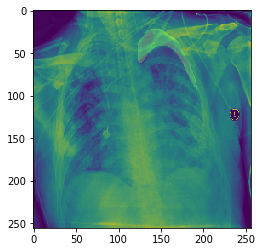

In [28]:
idx = 736
with zipfile.ZipFile(train_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    img = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
with zipfile.ZipFile(mask_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    mask = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
plt.figure()
plt.imshow(Image.fromarray(img))
plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()